In [ ]:
%%capture
!python3 -m venv venv
!source venv/bin/activate
!pip install tensorflow transformers

In [ ]:
import tensorflow as tf
from tensorflow.keras import activations, optimizers, losses
from transformers import DistilBertTokenizer, TFDistilBertForSequenceClassification
import pickle
import pandas as pd
import numpy as np
from numpy import std
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import LeaveOneOut,KFold
import os
from keras.layers import Activation, Concatenate, Conv1D, Dense, Dropout, Embedding   
from keras.layers import Flatten, Input, LSTM,  Permute
from keras import datasets, layers, models, regularizers
from transformers import DistilBertModel, TFDistilBertModel
import keras
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' # suppress Tensorflow messages

In [ ]:
""" 
    PROCESS DATA FRAME

    ARGS:
        (string) file location

    Return:
      Pandas dataframe filled with text from comma separated values (.csv) file

      deleted id column
      created row with numerical representation of class value
        0 - not sarcastic
        1 - sarcastic
"""
def process_data(s):
  #'/content/drive/MyDrive/~MTSU/research/Corpus/GEN-sarc-notsarc.csv'
  dataframe = pd.read_csv(s,sep=',',dtype=str,na_values=0)
  del dataframe['id']
  dataframe['label'] = dataframe['class'].map({'notsarc':0,'sarc':1})
  dataframe = dataframe.dropna(how='any',axis=0)
  dataframe = shuffle(dataframe)  
  return dataframe

# DISTILBERT TOKENIZATION AND EMBEDDING

In [ ]:
log_dir='/content/drive/MyDrive/~MTSU/research/data/Bert/CNN_Model/'
model_save_path='/content/drive/MyDrive/~MTSU/research/data/Bert/CNN_Model/glove_model.h5'

In [ ]:
sarc_df = process_data('/content/drive/MyDrive/~MTSU/research/Corpus/GEN-sarc-notsarc.csv')

In [ ]:
sarc_df.head()

,class,text,label
2943,sarc,"Liar, liar, pants on fire. You pro gay sex hea...",1
1894,notsarc,"It should, but between you me and the wall, yo...",0
1429,notsarc,What do you mean by this? Could we not have th...,0
2512,notsarc,The advantage is to the operators of the vesse...,0
2585,notsarc,[quote=Galileo]Congress has justified its regu...,0


In [ ]:
X = list(sarc_df['text'])
labels = list(sarc_df['label'])

In [ ]:
X[0:5]

["Liar, liar, pants on fire. You pro gay sex heathens haven't a clue what's coming your way. And you don't have to like it.\r\n",
 "It should, but between you me and the wall, you know it won't though.",
 'What do you mean by this? Could we not have the law treat under-18 capital offenders on an individual basis, determining whether the individual offenders in the individual cases were sufficiently developed?Also, what would you say to the response that our current law provides that juveniles are sufficiently developed enough to have the responsibility, without parental involvement, to decide whether to obtain an abortion? Is it not a conflict to say juveniles should not be eligible for the death penalty because they are not morally developed enough, but at the same time say juveniles are morally developed enough to decide whether to obtain an abortion without involving their parents?',
 "The advantage is to the operators of the vessel being attacked.   The attackers need to (a) keep t

In [ ]:
MODEL_NAME = 'distilbert-base-uncased'
MAX_LEN = 200

phrase = X[0]

tokenizer = DistilBertTokenizer.from_pretrained(MODEL_NAME)

inputs = tokenizer(phrase, max_length=MAX_LEN, truncation=True, padding=True)

print(f'Phrase: \'{phrase}\'')
print(f'input ids: {inputs["input_ids"]}')
print(f'attention mask: {inputs["attention_mask"]}')

Phrase: 'Liar, liar, pants on fire. You pro gay sex heathens haven't a clue what's coming your way. And you don't have to like it.
'
input ids: [101, 16374, 1010, 16374, 1010, 6471, 2006, 2543, 1012, 2017, 4013, 5637, 3348, 9895, 6132, 4033, 1005, 1056, 1037, 9789, 2054, 1005, 1055, 2746, 2115, 2126, 1012, 1998, 2017, 2123, 1005, 1056, 2031, 2000, 2066, 2009, 1012, 102]
attention mask: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


In [ ]:
def construct_encodings(x, tkzr, max_len, trucation=True, padding=True):
    """Pad each sentence to the maximum sentence length and encode tokens to
    their index in the vocabulary.

    Returns: SEQUENCES
        input_ids 
        attention_masks 
    """
    return tkzr(x, max_length=max_len, truncation=trucation, padding=padding)
    

In [ ]:
encodings = construct_encodings(X, tokenizer, max_len=MAX_LEN)

In [ ]:
list(encodings)

['input_ids', 'attention_mask']

In [ ]:
'''concept FOR setting up dataset from encodings'''

'''def construct_tfdataset(encodings, y=None):
    if y:
        return tf.data.Dataset.from_tensor_slices((dict(encodings),y))
    else:
        # this case is used when making predictions on unseen samples after training
        return tf.data.Dataset.from_tensor_slices(dict(encodings))


tfdataset = construct_tfdataset(encodings, labels)

TEST_SPLIT = 0.2
BATCH_SIZE = 2
num_classes = len(np.unique(labels))

train_size = int(len(X) * (1-TEST_SPLIT))

tfdataset = tfdataset.shuffle(len(X))
tfdataset_train = tfdataset.take(train_size)
tfdataset_test = tfdataset.skip(train_size)

tfdataset_train = tfdataset_train.batch(BATCH_SIZE)
tfdataset_test = tfdataset_test.batch(BATCH_SIZE)


tfdataset_train"""

In [ ]:
dbert_model = TFDistilBertModel.from_pretrained(MODEL_NAME,trainable=False)

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertModel: ['vocab_projector', 'vocab_transform', 'activation_13', 'vocab_layer_norm']
- This IS expected if you are initializing TFDistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFDistilBertModel were initialized from the model checkpoint at distilbert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


In [ ]:
class L_MODEL(tf.keras.Model):
    
    def __init__(self,
                 vocabulary_size,
                 embedding_dimensions=128,
                 cnn_filters=50,
                 dnn_units=512,
                 model_output_classes=2,
                 dropout_rate=0.1,
                 training=False,
                 name="text_model"):
        super(L_MODEL, self).__init__(name=name)
        
        self.embedding = layers.Embedding(vocabulary_size,
                                          embedding_dimensions)
        self.cnn_layer1 = layers.Conv1D(filters=cnn_filters,
                                        kernel_size=2,
                                        padding="valid",
                                        activation="relu")
        self.cnn_layer2 = layers.Conv1D(filters=cnn_filters,
                                        kernel_size=3,
                                        padding="valid",
                                        activation="relu")
        self.cnn_layer3 = layers.Conv1D(filters=cnn_filters,
                                        kernel_size=4,
                                        padding="valid",
                                        activation="relu")
        self.pool = layers.GlobalMaxPool1D()
        
        self.dense_1 = layers.Dense(units=dnn_units, activation="relu")
        self.dropout = layers.Dropout(rate=dropout_rate)
        if model_output_classes == 2:
            self.last_dense = layers.Dense(units=1,
                                           activation="sigmoid")
        else:
            self.last_dense = layers.Dense(units=model_output_classes,
                                           activation="softmax")
    
    def call(self, inputs, training):
        l = self.embedding(inputs)
        l_1 = self.cnn_layer1(l) 
        l_1 = self.pool(l_1) 
        l_2 = self.cnn_layer2(l) 
        l_2 = self.pool(l_2)
        l_3 = self.cnn_layer3(l)
        l_3 = self.pool(l_3) 
        
        concatenated = tf.concat([l_1, l_2, l_3], axis=-1) # (batch_size, 3 * cnn_filters)
        concatenated = self.dense_1(concatenated)
        concatenated = self.dropout(concatenated, training)
        model_output = self.last_dense(concatenated)
        
        return model_output

In [ ]:
'''
    PREDICTOR
      creates dataset from text passed,
      constructs tokenization
      compares predictions to existing labels

      return:
          prediction statistics
'''

def create_predictor(model, model_name, max_len, data ):
  tkzr = DistilBertTokenizer.from_pretrained(model_name)
  def predict_sarc(text):
      x = [text]

      encodings = construct_encodings(x, tkzr, max_len=max_len)
      preds = model.predict(encodings['input_ids'])
      preds = activations.softmax(tf.convert_to_tensor(preds)).numpy()
      return preds[0][0]
    
  return predict_sarc



In [ ]:
'''
      MODEL CONFIG VARIABLES
'''
VOCAB_LENGTH = len(tokenizer.vocab)
EMB_DIM = 200
CNN_FILTERS = 100
DNN_UNITS = 256
OUTPUT_CLASSES = 2

DROPOUT_RATE = 0.5

NB_EPOCHS = 3
k = 5
kf = KFold(n_splits=k, shuffle=False)

In [ ]:
from sklearn.model_selection import train_test_split,KFold , StratifiedKFold

In [ ]:
callbacks = [tf.keras.callbacks.ModelCheckpoint(filepath=model_save_path,save_weights_only=True,monitor='val_accuracy',mode='max',save_best_only=False,save_freq=NB_EPOCHS),keras.callbacks.TensorBoard(log_dir=log_dir)]

In [ ]:
"""
  TRAIN MODEL 

    ARGS -
      x-train - input_ids training set
      x_valid - input_ids validation set
      y_train - label training set
      y_valid - label validation set
"""

def train_model(model, x_train,x_valid, y_train, y_val):
  if OUTPUT_CLASSES == 2:
    model.compile(loss="binary_crossentropy",
                       optimizer="adam",
                       metrics=["accuracy"])
  else:
    model.compile(loss="sparse_categorical_crossentropy",
                       optimizer="adam",
                       metrics=["sparse_categorical_accuracy"])

  history = model.fit(x_train, y=y_train,
              epochs=NB_EPOCHS, validation_data=(x_valid,y_val),callbacks=callbacks)
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.legend(['Training Loss','Validation Loss'])
  plt.xlabel('Epoch')
  plt.ylabel('CCE Loss')
  plt.show()
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.legend(['Training','Validation'])
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy (P)')
  plt.show()

Epoch 1/3
163/163 [==============================] - 9s 52ms/step - loss: 0.6090 - accuracy: 0.6635 - val_loss: 0.5388 - val_accuracy: 0.7278
Epoch 2/3
163/163 [==============================] - 9s 56ms/step - loss: 0.3885 - accuracy: 0.8363 - val_loss: 0.5423 - val_accuracy: 0.7446
Epoch 3/3
163/163 [==============================] - 8s 49ms/step - loss: 0.1187 - accuracy: 0.9645 - val_loss: 0.6393 - val_accuracy: 0.7400


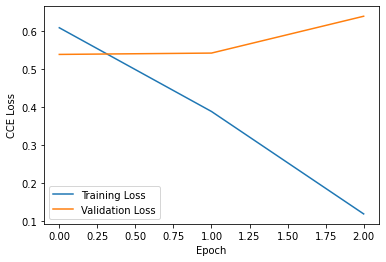

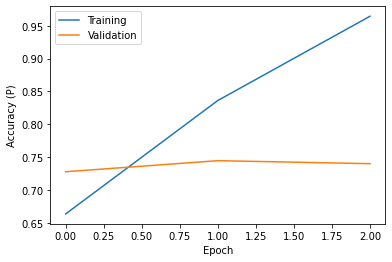

652/652 [==============================] - 2s 3ms/step - loss: 0.6393 - accuracy: 0.7400
{'loss': 0.6393432021141052, 'accuracy': 0.7400306463241577}
INFO:tensorflow:Assets written to: ram://4299c69d-b4ca-4223-a597-69a23b419bcf/assets


INFO:tensorflow:Assets written to: ram://4299c69d-b4ca-4223-a597-69a23b419bcf/assets


Epoch 1/3
163/163 [==============================] - 11s 63ms/step - loss: 0.6022 - accuracy: 0.6639 - val_loss: 0.5466 - val_accuracy: 0.7071
Epoch 2/3
163/163 [==============================] - 9s 55ms/step - loss: 0.3891 - accuracy: 0.8334 - val_loss: 0.5186 - val_accuracy: 0.7515
Epoch 3/3
163/163 [==============================] - 9s 55ms/step - loss: 0.1175 - accuracy: 0.9653 - val_loss: 0.6137 - val_accuracy: 0.7393


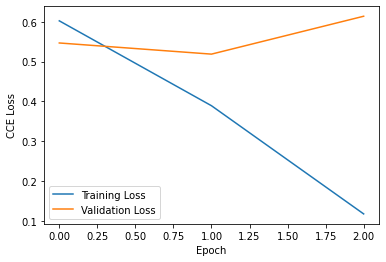

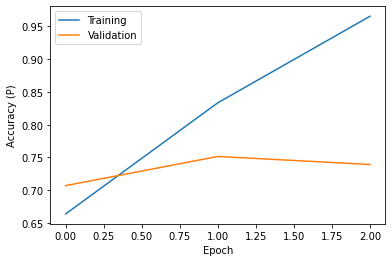

652/652 [==============================] - 2s 3ms/step - loss: 0.6137 - accuracy: 0.7393
{'loss': 0.6137197017669678, 'accuracy': 0.7392638325691223}
INFO:tensorflow:Assets written to: ram://8bf47cbd-5e4c-423b-aee7-77d0fed0b831/assets


INFO:tensorflow:Assets written to: ram://8bf47cbd-5e4c-423b-aee7-77d0fed0b831/assets


Epoch 1/3
163/163 [==============================] - 10s 58ms/step - loss: 0.6267 - accuracy: 0.6294 - val_loss: 0.5242 - val_accuracy: 0.7362
Epoch 2/3
163/163 [==============================] - 9s 54ms/step - loss: 0.4106 - accuracy: 0.8181 - val_loss: 0.5075 - val_accuracy: 0.7469
Epoch 3/3
163/163 [==============================] - 10s 59ms/step - loss: 0.1439 - accuracy: 0.9517 - val_loss: 0.6611 - val_accuracy: 0.7354


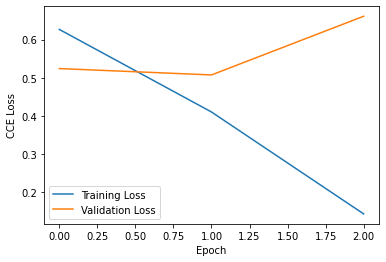

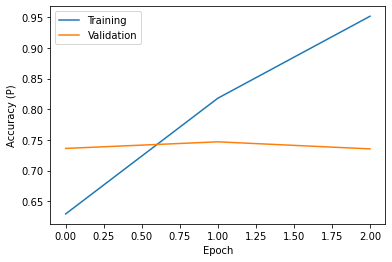

652/652 [==============================] - 4s 5ms/step - loss: 0.6611 - accuracy: 0.7354
{'loss': 0.6611268520355225, 'accuracy': 0.7354294657707214}
INFO:tensorflow:Assets written to: ram://6a25f7b6-d9cd-489f-8bfe-a87f1c6bb04c/assets


INFO:tensorflow:Assets written to: ram://6a25f7b6-d9cd-489f-8bfe-a87f1c6bb04c/assets


Epoch 1/3
163/163 [==============================] - 10s 59ms/step - loss: 0.6192 - accuracy: 0.6511 - val_loss: 0.5559 - val_accuracy: 0.7178
Epoch 2/3
163/163 [==============================] - 11s 67ms/step - loss: 0.4120 - accuracy: 0.8150 - val_loss: 0.5010 - val_accuracy: 0.7646
Epoch 3/3
163/163 [==============================] - 8s 50ms/step - loss: 0.1354 - accuracy: 0.9548 - val_loss: 0.6288 - val_accuracy: 0.7531


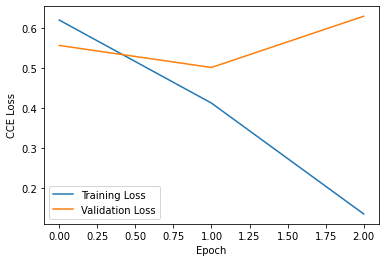

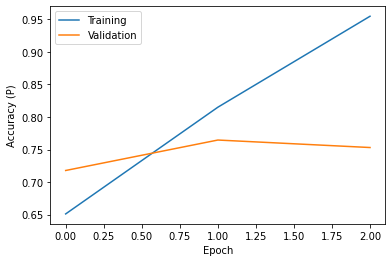

652/652 [==============================] - 2s 3ms/step - loss: 0.6288 - accuracy: 0.7531
{'loss': 0.6288344860076904, 'accuracy': 0.7530674934387207}
INFO:tensorflow:Assets written to: ram://37897a04-e379-4040-a3d7-3bc38fd7f5d2/assets


INFO:tensorflow:Assets written to: ram://37897a04-e379-4040-a3d7-3bc38fd7f5d2/assets


Epoch 1/3
163/163 [==============================] - 11s 62ms/step - loss: 0.6130 - accuracy: 0.6587 - val_loss: 0.5160 - val_accuracy: 0.7362
Epoch 2/3
163/163 [==============================] - 8s 52ms/step - loss: 0.4087 - accuracy: 0.8140 - val_loss: 0.4942 - val_accuracy: 0.7515
Epoch 3/3
163/163 [==============================] - 9s 53ms/step - loss: 0.1372 - accuracy: 0.9592 - val_loss: 0.5861 - val_accuracy: 0.7400


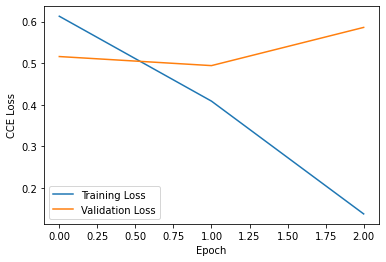

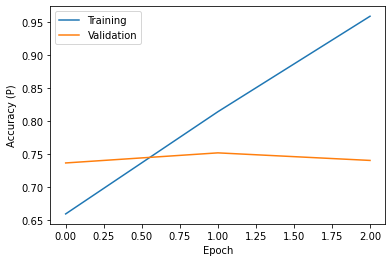

652/652 [==============================] - 2s 3ms/step - loss: 0.5861 - accuracy: 0.7400
{'loss': 0.5861396789550781, 'accuracy': 0.7400306463241577}
INFO:tensorflow:Assets written to: ram://8830439a-edb3-4d05-9468-02c99e113c02/assets


INFO:tensorflow:Assets written to: ram://8830439a-edb3-4d05-9468-02c99e113c02/assets


In [ ]:
ids = np.asarray(encodings['input_ids'])
masks = np.array(encodings['attention_mask'])
labels = np.array(labels)
ids[0:5]
'''
    K FOLD VALIDATION LOOP

   X   create input_id training and validation sets in 
   Y   create label training and validation sets in
   M   create attention_mask training set in 

   model = none clears memory
   Create model

   Call train model function for learning

   benchmarks saves in evaluate and printed
   predictor made from model and compared to label set


   save model and weights in log_directory
'''
for train_index, val_index in kf.split(ids,masks,labels):
      #print("Training on fold " + str(index+1) + "/5..." )   # Generate batches from indices
      X_train, X_val = ids[train_index], ids[val_index]
      M_train, M_val = masks[train_index], masks[val_index]
      Y_train, Y_val = labels[train_index], labels[val_index]
     

      
      #print(Y_train[1:5], "\n    ", M_train[1:5], "\n    ", X_train[1:5])
      #print("Training new iteration on " + str(X_train.shape) + " training samples, " + str(X_val.shape) + " validation samples, this may be a while...")
      model = None
      model = L_MODEL(vocabulary_size=VOCAB_LENGTH,
                        embedding_dimensions=EMB_DIM,
                        cnn_filters=CNN_FILTERS,
                        dnn_units=DNN_UNITS,
                        model_output_classes=OUTPUT_CLASSES,
                        dropout_rate=DROPOUT_RATE)
      history = train_model(model, X_train, X_val, Y_train, Y_val)
      benchmarks = model.evaluate(X_val,y=Y_val, return_dict=True, batch_size=BATCH_SIZE)
      print(benchmarks)
      clf = create_predictor(model, MODEL_NAME, MAX_LEN, (X_val,Y_val))
      
      dbert_model.save_pretrained(log_dir)
      with open(model_save_path, 'wb') as f:
          pickle.dump((model, MAX_LEN), f)

In [ ]:
cnn_preds = cnn_trained_model.predict([cnn_val_inp,cnn_val_mask],batch_size=16)
cnn_pred_labels = cnn_preds.argmax(axis=1)
cnn_f1 = f1_score(cnn_val_label,cnn_pred_labels)
cnn_f1

0.7617728531855956

In [ ]:
print('F1 score',cnn_f1)
print('Classification Report')
print(classification_report(cnn_val_label,cnn_pred_labels,target_names=cnn_target_names))

F1 score 0.7617728531855956
Classification Report
              precision    recall  f1-score   support

     notsarc       0.80      0.63      0.70       651
        sarc       0.70      0.84      0.76       653

    accuracy                           0.74      1304
   macro avg       0.75      0.74      0.73      1304
weighted avg       0.75      0.74      0.73      1304

